<h1>Sieci neuronowe - ćwiczenie 4</h1>

In [1]:
!pip install ucimlrepo
!pip install tensorflow


[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow.keras.layers import Dense

<h3>Przygotowanie danych na podstawie poprzedniego ćwiczenia</h3>

In [3]:
# original code from https://archive.ics.uci.edu/dataset/45/heart+disease
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
heart_data = heart_disease.data.original

In [4]:
df: pd.DataFrame = heart_data

# repearing of the inbalnace in classification and removing null values
df["num"] = df["num"].replace([2, 3, 4], 1) #change classes to binary classification
print(df["num"].value_counts())

#get null values of ca and remove them
null_idx = df[df["ca"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

#get null values of thel and remove them
null_idx = df[df["thal"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

# balance classes to same amount 138
random_idx = df.query("num == 0").sample(df["num"].value_counts()[0] - df["num"].value_counts()[1]).index 
df = df.drop(random_idx)
df = df.reset_index(drop=True)
print(df["num"].value_counts())


def category_to_dummy(column: str, targets: list[str]):
    result_categories = pd.get_dummies(column).astype(int)
    result_categories.columns = targets
    return result_categories

df_without_num = pd.concat([df, 
                            category_to_dummy(df["cp"], ["typical angina", "atypical angina", "non-anginal pain", "asymptomatic"]),
                            category_to_dummy(df["restecg"], ["normal", "having ST-T wave abnormality", "left ventricular hypertrophy by Estes' criteria"]),
                            category_to_dummy(df["slope"], ["upsloping", "flat", "downsloping"]),
                            category_to_dummy(df["thal"], ["normal", "fixed defect", "reversable defect"]),
                            ], axis=1)

df_without_num = df_without_num.loc[:, df_without_num.columns != "cp"]
df_without_num = df_without_num.loc[:, df_without_num.columns != "restecg"]
df_without_num = df_without_num.loc[:, df_without_num.columns != "slope"]
df_without_num = df_without_num.loc[:, df_without_num.columns != "thal"]
df_without_num = df_without_num.loc[:, df_without_num.columns != "num"]

std_features = (df_without_num - df_without_num.mean() )/ df_without_num.std() #(value-mean)/variance
# std_features = ((df_without_num - df_without_num.min()) / (df_without_num.max() - df_without_num.min()))

result_df = std_features
result_df["heart_disease"] = df["num"]

# data not standarized 4. Danych znormalizowanych i nieznormalizowanych
n_std_result = df_without_num
n_std_result["heart_disease"] = df["num"]


result_df

num
0    164
1    139
Name: count, dtype: int64
Index([166, 192, 287, 302], dtype='int64')
num
0    161
1    138
Name: count, dtype: int64
Index([87, 264], dtype='int64')
num
0    160
1    137
Name: count, dtype: int64
num
0    137
1    137
Name: count, dtype: int64


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,typical angina,...,normal,having ST-T wave abnormality,left ventricular hypertrophy by Estes' criteria,upsloping,flat,downsloping,normal,fixed defect,reversable defect,heart_disease
0,0.924209,0.675113,0.713241,-0.286157,2.379535,0.039583,-0.715498,1.007245,-0.731582,3.297456,...,-0.969443,-0.121494,0.998174,-0.900887,-0.948411,3.464628,-1.058267,3.881040,-0.829961,0
1,1.377018,0.675113,1.550789,0.716152,-0.418716,-1.789803,1.392528,0.331639,2.416901,-0.302157,...,-0.969443,-0.121494,0.998174,-0.900887,1.050547,-0.287578,0.941493,-0.256723,-0.829961,1
2,1.377018,0.675113,-0.682673,-0.361803,-0.418716,-0.875110,1.392528,1.260597,1.367407,-0.302157,...,-0.969443,-0.121494,0.998174,-0.900887,1.050547,-0.287578,-1.058267,-0.256723,1.200479,1
3,-2.019047,0.675113,-0.124308,0.035338,-0.418716,1.651184,-0.715498,2.020654,-0.731582,-0.302157,...,1.027755,-0.121494,-0.998174,-0.900887,-0.948411,3.464628,0.941493,-0.256723,-0.829961,0
4,-1.566239,-1.475828,-0.124308,-0.834591,-0.418716,0.997832,-0.715498,0.247188,-0.731582,-0.302157,...,-0.969443,-0.121494,0.998174,1.105966,-0.948411,-0.287578,0.941493,-0.256723,-0.829961,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,0.244996,-1.475828,0.434058,-0.134865,-0.418716,-1.136451,1.392528,-0.766221,-0.731582,-0.302157,...,1.027755,-0.121494,-0.998174,-0.900887,1.050547,-0.287578,-1.058267,-0.256723,1.200479,1
270,-1.113430,0.675113,-1.241039,0.300099,-0.418716,-0.744440,-0.715498,0.078286,-0.731582,3.297456,...,1.027755,-0.121494,-0.998174,-0.900887,1.050547,-0.287578,-1.058267,-0.256723,1.200479,1
271,1.490220,0.675113,0.657404,-1.042617,2.379535,-0.352428,-0.715498,1.936204,1.367407,-0.302157,...,1.027755,-0.121494,-0.998174,-0.900887,1.050547,-0.287578,-1.058267,-0.256723,1.200479,1
272,0.244996,0.675113,-0.124308,-2.215130,-0.418716,-1.484905,1.392528,0.078286,0.317913,-0.302157,...,1.027755,-0.121494,-0.998174,-0.900887,1.050547,-0.287578,-1.058267,-0.256723,1.200479,1


In [5]:
def train_test_split(features, targets, percentage):
    choices = np.random.choice(range(features.shape[0]), size=(int(features.shape[0] * percentage/100),), replace=False) 
    split = np.zeros(features.shape[0], dtype=bool)
    split[choices] = True

    return features[split], targets[split], features[~split], targets[~split]

In [6]:
features = result_df.loc[:, result_df.columns != "heart_disease"].to_numpy()
targets = result_df["heart_disease"].to_numpy()

x_train, y_train, x_test, y_test = train_test_split(features, targets, 70)

<h1>Przygotowanie modelu</h1>

In [7]:
class MultilayerNetwork(tf.keras.Model):
    def __init__(self, hidden_layers_sizes: tuple, input_size: int, output_size: int):
        super(MultilayerNetwork, self).__init__()

        self._layers = []
        curr_size = input_size
        for hidden_layer_size in hidden_layers_sizes:
            layer = tf.keras.layers.Dense(hidden_layer_size, activation="sigmoid", input_shape=(curr_size,))
            self._layers.append(layer)
            curr_size = hidden_layer_size
        output_layer = tf.keras.layers.Dense(output_size, activation="sigmoid", input_shape=(curr_size,))    
        self._layers.append(output_layer)
        
    def call(self, inputs):
        x = inputs
        for layer in self._layers:
            x = layer(x)
        return x        

In [8]:
def train_model(model, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, batch_size: int,
                optimizer, loss, max_iter, verb=False):
    
    losses = []
    losses_test = []

    accuracy = []
    precision = []
    f_score = []
    recalls = []

    #fix shape of y data to match further calculations
    if len(y_test.shape) == 1:
        y_test = tf.transpose(y_test)

    if len(y_train.shape) == 1:
        y_train = tf.transpose(y_train)

    if batch_size > x_train.shape[0]:
        batch_size = x_train.shape[0]

    for index in range(max_iter): #learn for max_iter     
        # shuffle training data
        shuffle = np.random.permutation(x_train.shape[0])
        x_train_shuffled = tf.gather(x_train, shuffle)
        y_train_shuffled = tf.gather(y_train, shuffle)

        # for each batch perform learning
        for batch_start_index in range(0, x_train.shape[0], batch_size):
            x_train_batch = x_train_shuffled[batch_start_index:batch_start_index+batch_size] 
            y_train_batch = y_train_shuffled[batch_start_index:batch_start_index+batch_size] 

            with tf.GradientTape() as tape:
                y_pred = model(x_train_batch)
                y_pred = tf.squeeze(y_pred)
                loss_value = loss(y_train_batch, y_pred)
                loss_value = tf.reduce_mean(loss_value)
                
            gradient = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(gradient, model.trainable_variables))
        
        losses.append(loss_value.numpy())
        test_pred = model(x_test)
        test_pred = tf.squeeze(test_pred)
        loss_test_value = loss(y_test, test_pred)
        loss_test_value = tf.reduce_mean(loss_test_value)
        losses_test.append(loss_test_value.numpy())

        test_pred = tf.where(test_pred >= 0.5, 1.0, test_pred)
        test_pred = tf.where(test_pred < 0.5, 0.0, test_pred)

        #calculate scores for each iteration
        accuracy.append(metrics.accuracy_score(y_test, test_pred))
        precision.append(metrics.precision_score(y_test, test_pred))
        f_score.append(metrics.f1_score(y_test, test_pred))
        recalls.append(metrics.recall_score(y_test, test_pred))

        if verb and index % 100 == 0:
            print("---------------------------------------------- Interation " + str(index))
            print("Train loss on " + str(index) + " iteration: ", losses[index])
            print("Test loss on " + str(index) + " iteration: ", losses_test[index])
            print("Accuracy on " + str(index) + " iteration: ", accuracy[index])
            print("Precision on " + str(index) + " iteration: ", precision[index])
            print("Recall on " + str(index) + " iteration: ", recalls[index])
            print("Fscore on " + str(index) + " iteration: ", f_score[index])
            print("----------------------------------------------\n")

    print("Result of learning process for " + str(max_iter) + " iterations")
    print("--------------------------------------------------------\n")
    print("Train loss: ", losses[-1])
    print("Test loss: ", losses_test[-1])
    print("----------------------------------------------\n")
    print("Scores")
    print("Accuracy: ", accuracy[-1])
    print("Precision: ", precision[-1])
    print("F_score: ", f_score[-1])
    print("Recall: ", recalls[-1])    
    return losses, losses_test, accuracy, f_score, recalls

In [9]:
def plot_learning(losses: list, losses_test: list, title: str, axs = None):
    if axs == None:
        plt.plot(np.arange(len(losses)), losses, label="Train Loss")
        plt.plot(np.arange(len(losses)), losses_test, label="Test loss")
        plt.plot(np.convolve(losses, np.ones(30)/30, mode='valid'), label="Train loss smooth") #rolling avarage to smooth line
        plt.title(title)
        plt.legend()
        plt.show()
    else:
        axs.plot(np.arange(len(losses)), losses, label="Train Loss")
        axs.plot(np.arange(len(losses)), losses_test, label="Test loss")
        axs.plot(np.convolve(losses, np.ones(30)/30, mode='valid'), label="Train loss smooth") #rolling avarage to smooth line
        axs.set_title(title)
        axs.legend()

<p>Zmiana danych na tensory</p>

In [10]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)

In [11]:
import warnings
warnings.filterwarnings('ignore') #hide warning for precision (first iterations have no precision and python gives a warning, to clear output hide it)

In [12]:
#2. Rozmiar batcha
batch_size_small = 10
batch_size_middle = 30
batch_size_large = 120

#3. Wartość współczynnika uczenia dla różnych optimizerów
learning_rate_1 = 0.001
learning_rate_2 = 0.01

optimizer_SGD_lr_2 = tf.keras.optimizers.legacy.SGD(learning_rate_2)
optimizer_Adam_lr_2 = tf.keras.optimizers.legacy.Adam(learning_rate_2)
optimizer_Nadam_lr_2 = tf.keras.optimizers.legacy.Nadam(learning_rate_2)

#1. Wybrany optimizer (SGD i dwa inne)
optimizer_SGD = tf.keras.optimizers.legacy.SGD(learning_rate_1)
optimizer_Adam = tf.keras.optimizers.legacy.Adam(learning_rate_1)
optimizer_Nadam = tf.keras.optimizers.legacy.Nadam(learning_rate_1)

max_iter = 1000
loss = tf.keras.losses.binary_crossentropy
verbose = False

options_title = ["Optimizer SGD lr: " + str(learning_rate_1) + " batch: " + str(batch_size_middle), 
                 "Optimizer Adam lr: " + str(learning_rate_1) + " batch: " + str(batch_size_middle), 
                 "Optimizer Nadam lr: " + str(learning_rate_1) + " batch: " + str(batch_size_middle), 
                 "Optimizer Adam lr: " + str(learning_rate_1) + " batch: " + str(batch_size_small), 
                 "Optimizer Adam lr: " + str(learning_rate_1) + " batch: " + str(batch_size_large), 
                 "Optimizer SGD lr: " + str(learning_rate_2) + " batch: " + str(batch_size_middle), 
                 "Optimizer Adam lr: " + str(learning_rate_2) + " batch: " + str(batch_size_middle), 
                 "Optimizer Nadam lr: " + str(learning_rate_2) + " batch: " + str(batch_size_middle)
                 ]

options = [[optimizer_SGD, batch_size_middle], [optimizer_Adam, batch_size_middle], [optimizer_Nadam, batch_size_middle],
           [optimizer_Adam, batch_size_small], [optimizer_Adam, batch_size_large],
           [optimizer_SGD_lr_2, batch_size_middle], [optimizer_Adam_lr_2, batch_size_middle], [optimizer_Nadam_lr_2, batch_size_middle]]

In [13]:
results = []
models = []
for index_option, option in enumerate(options):
    print("\n" + options_title[index_option])
    model = MultilayerNetwork((10,10,10), x_train.shape[1], 1)
    result = train_model(model, x_train, y_train, x_test, y_test, option[1], option[0], loss, max_iter, verb=verbose)
    models.append(model)
    results.append(result)


Optimizer SGD lr: 0.001 batch: 30


Result of learning process for 1000 iterations
--------------------------------------------------------

Train loss:  0.6817959
Test loss:  0.6890474
----------------------------------------------

Scores
Accuracy:  0.4819277108433735
Precision:  0.0
F_score:  0.0
Recall:  0.0

Optimizer Adam lr: 0.001 batch: 30
Result of learning process for 1000 iterations
--------------------------------------------------------

Train loss:  0.35598376
Test loss:  0.48738727
----------------------------------------------

Scores
Accuracy:  0.8554216867469879
Precision:  0.8444444444444444
F_score:  0.8636363636363636
Recall:  0.8837209302325582

Optimizer Nadam lr: 0.001 batch: 30
Result of learning process for 1000 iterations
--------------------------------------------------------

Train loss:  0.3918525
Test loss:  0.503807
----------------------------------------------

Scores
Accuracy:  0.8192771084337349
Precision:  0.85
F_score:  0.8192771084337349
Recall:  0.7906976744186046

Optimizer Adam 

In [14]:
# features_n_std = n_std_result.loc[:, result_df.columns != "heart_disease"].to_numpy()
# targets_n_std = n_std_result["heart_disease"].to_numpy()

# x_train_n_std, y_train_n_std, x_test_n_std, y_test_n_std = train_test_split(features_n_std, targets_n_std, 70)

# model_std = MultilayerNetwork(hidden2)
# result = model_std.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.5, verb=True)
# models.append(model_std)
# results.append(result)

# model_n_std = MultilayerNetwork(hidden2)
# result = model_n_std.optimize(x_train_n_std, y_train_n_std, x_test_n_std, y_test_n_std, 30, 0.001, max_iter, 0.5, verb=True)
# models.append(model_n_std)
# results.append(result)

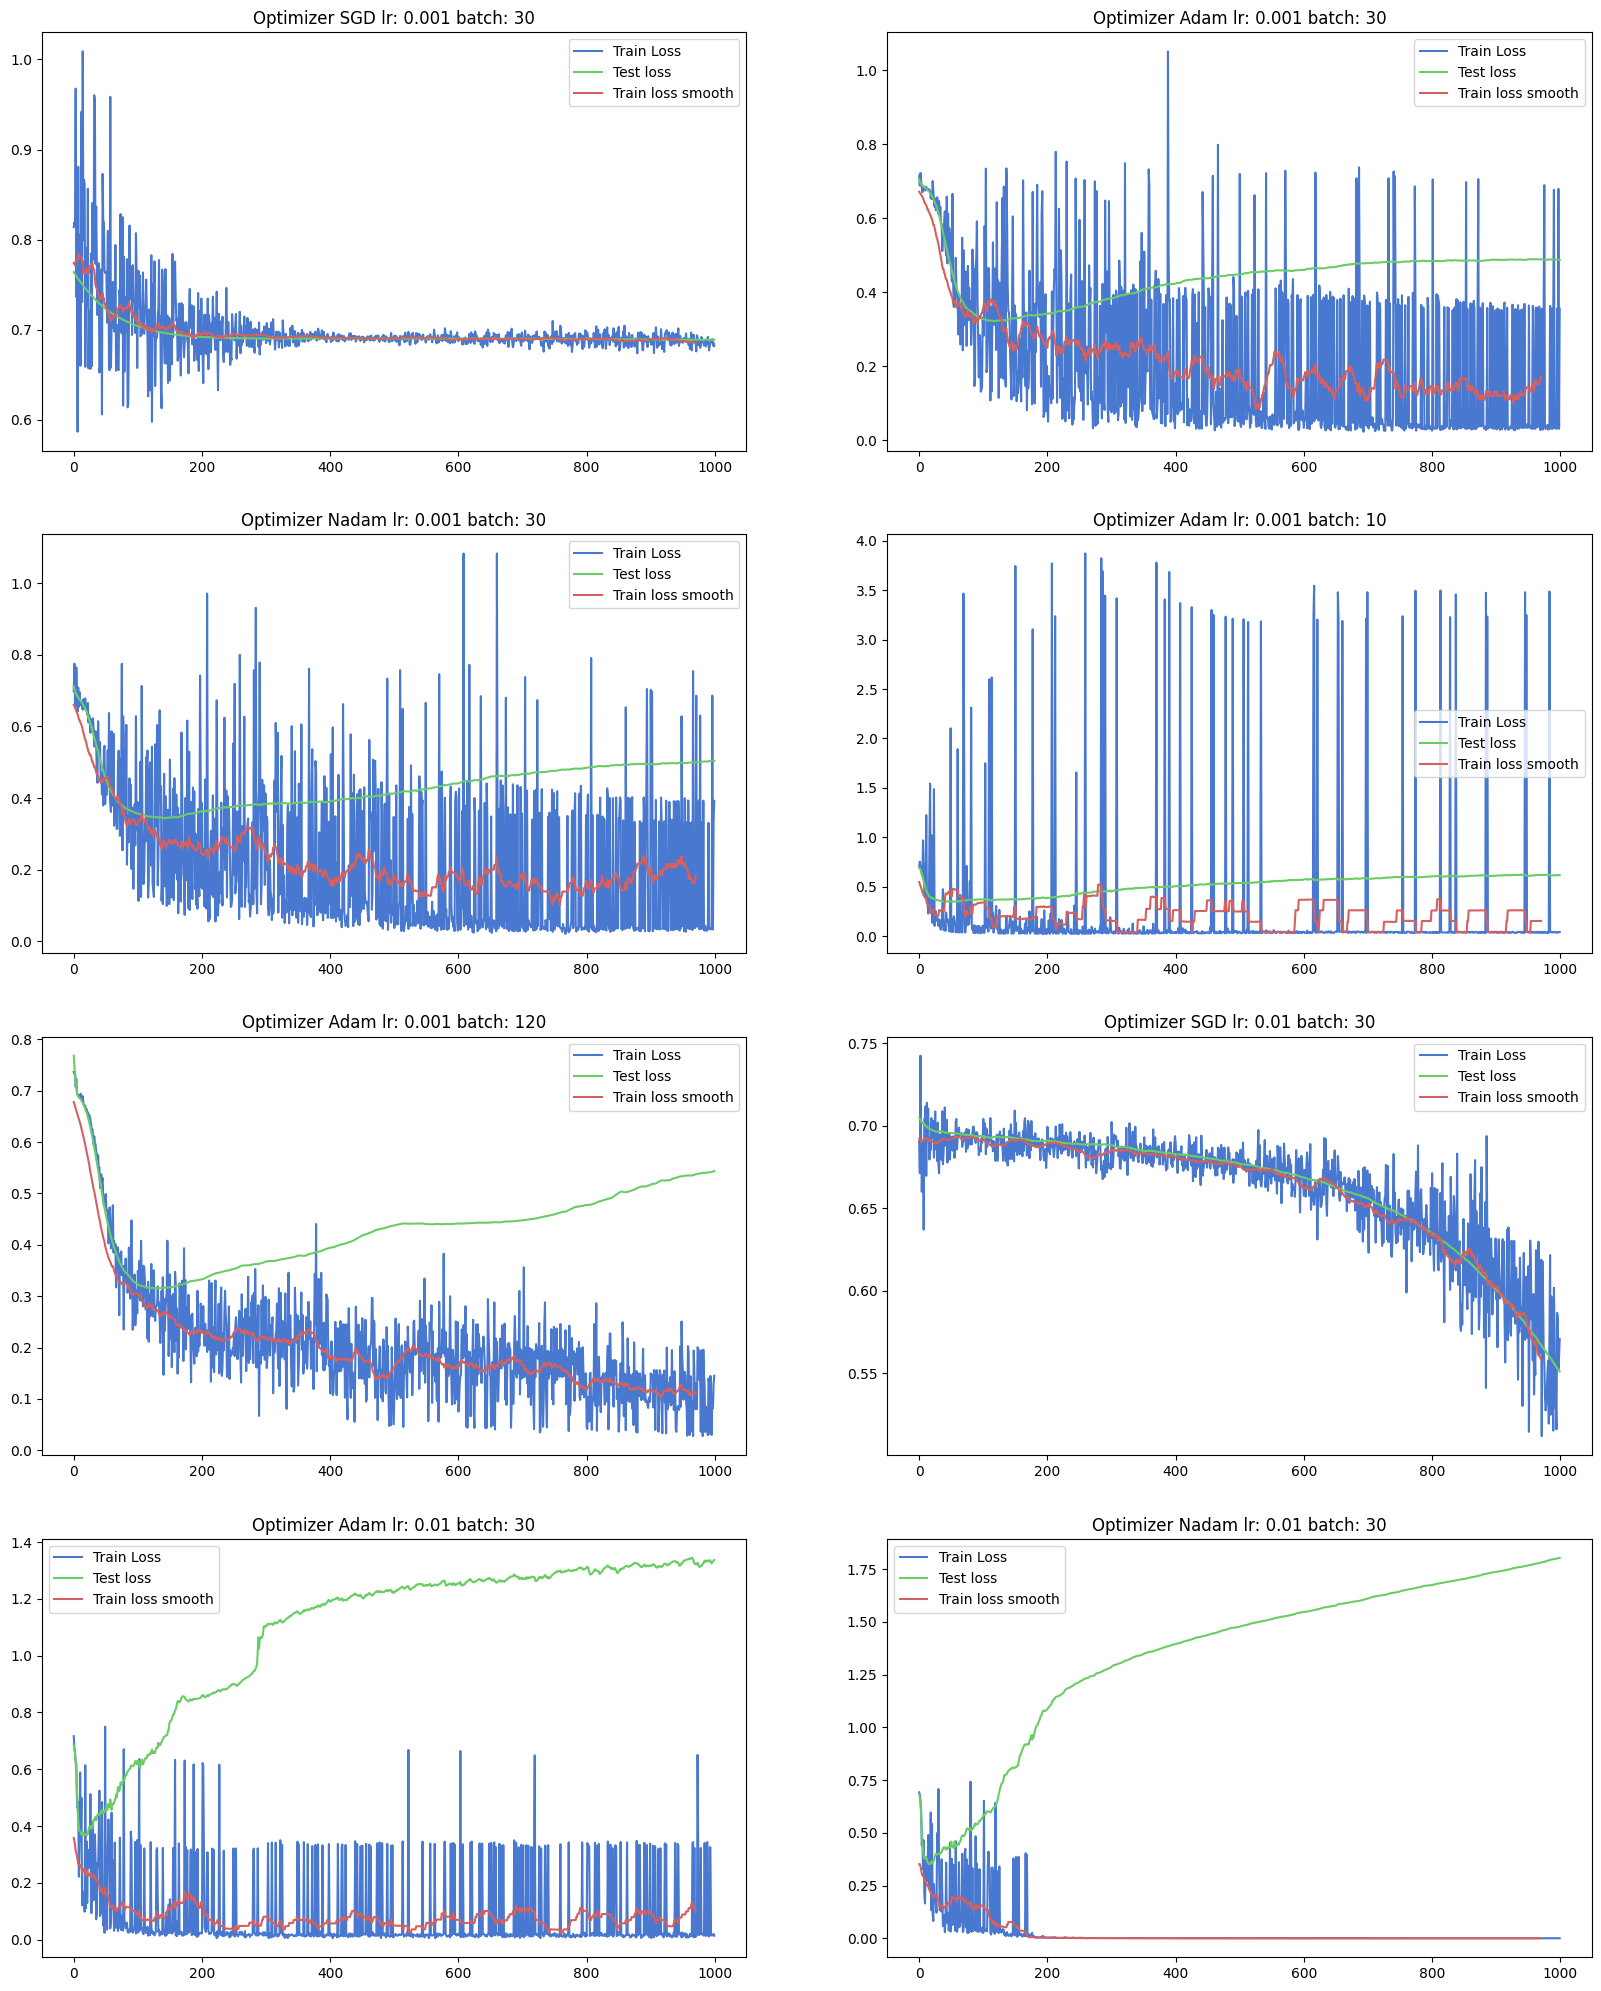

In [15]:
plt.style.use('seaborn-muted')
fig, axs = plt.subplots(4, 2, figsize=(20, 25))

for model_index, model in enumerate(models):
    x_index = int(model_index / 2)
    y_index = int(model_index % 2)
    plot_learning(results[model_index][0], results[model_index][1], options_title[model_index], axs[x_index, y_index])
    